In [71]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt
import imutils
import easyocr

class LicensePlateDetector:
    def __init__(self, pth_weights: str, pth_cfg: str, pth_classes: str):
        self.net = cv2.dnn.readNet(pth_weights, pth_cfg) #detects an origin framework of trained model and calls an appropriate function
        self.classes = []
        with open(pth_classes, 'r') as f: #Reads classes from txt file & stores it in 'classes' variable
            self.classes = f.read().splitlines()
        self.font = cv2.FONT_HERSHEY_PLAIN
        self.color = (255, 0, 0)
        self.coordinates = None
        self.img = None
        self.fig_image = None
        self.roi_image = None
        
#detect a license plate from the input image and draw a rectangle around it        
    def detect(self, img_path: str):
        orig = cv2.imread(img_path)
        self.img = orig
        img = orig.copy()
        height, width, _ = img.shape
        # read image into BLOB
        blob = cv2.dnn.blobFromImage(img, 1 / 255, (416, 416), (0, 0, 0), swapRB=True, crop=False)
        # pass the BLOB through the model to get detections
        self.net.setInput(blob)
        output_layer_names = self.net.getUnconnectedOutLayersNames() #gives a list of all layers used in a network
        layer_outputs = self.net.forward(output_layer_names) #gives Numpy ndarray as output to plot box on the given input image. 
        boxes = []
        confidences = []
        class_ids = []

        for output in layer_outputs:
            for detection in output:
                #extract the class ID and confidence of the current object detection
                scores = detection[5:]
                class_id = np.argmax(scores) 
                confidence = scores[class_id]
                # filter out weak predictions by ensuring the detected probability is greater than the minimum probability 0.2
                global x
                if confidence > 0.0:
                    center_x = int(detection[0] * width)
                    center_y = int(detection[1] * height)
                    w = int(detection[2] * width)
                    h = int(detection[3] * height)
                    x = int(center_x - w / 2)
                    y = int(center_y - h / 2)
                    # update list of bounding box coordinates, confidences, and class IDs 
                    boxes.append([x, y, w, h])
                    confidences.append((float(confidence)))
                    class_ids.append(class_id)
        #Apply non-maximum suppression to suppress weak, overlapping bounding boxes
        indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.2, 0.4)

        #Ensure at least one detection exists
        if len(indexes) > 0:
            for i in indexes.flatten(): #Loop over the indexes we're keeping
                x, y, w, h = boxes[i]
                label = str(self.classes[class_ids[i]])
                confidence = str(round(confidences[i],2))
                cv2.rectangle(img, (x,y), (x + w, y + h), self.color, 15)
                cv2.putText(img, label + ' ' + confidence, (x, y + 20), self.font, 3, (255, 255, 255), 3)
        self.fig_image = img
        self.coordinates = (x, y, w, h)
        return
    
#Crop the detected license plate from an image to apply some OCR to extract the text    
    def crop_plate(self):
        x, y, w, h = self.coordinates
        roi = self.img[y:y + h, x:x + w]
        self.roi_image = roi
        return

In [72]:
lpd = LicensePlateDetector(
    pth_weights='yolov3-train_final.weights', 
    pth_cfg='yolov3_testing.cfg', 
    pth_classes='classes.txt'
)

read_char= easyocr.Reader(['bn'])  #bangla character reading with 'bn'

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


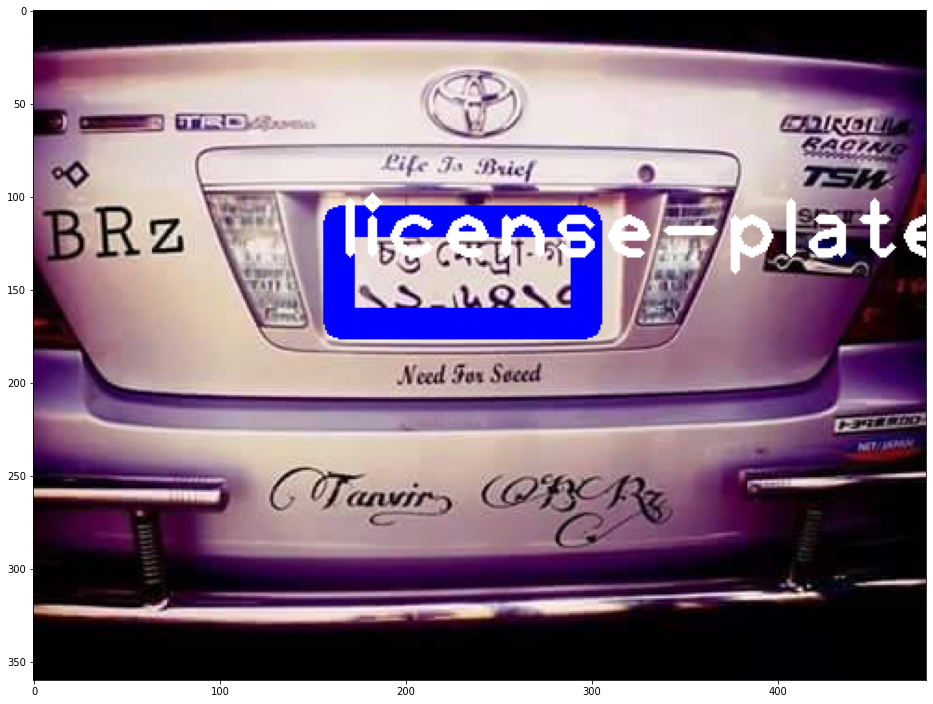

[([[16, 4], [126, 4], [126, 32], [16, 32]],
  'চট্ট মেট্রো-গ',
  0.5152070073652495),
 ([[8, 30], [132, 30], [132, 55], [8, 55]], '১২-৬৪১৭', 0.9193279677886901)]

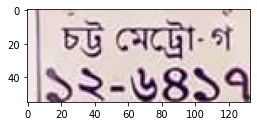

In [73]:
# Detect license plate
lpd.detect('73.jpg')

# Plot original image with rectangle around the plate
plt.figure(figsize=(16,16))
plt.imshow(cv2.cvtColor(lpd.fig_image, cv2.COLOR_BGR2RGB))
plt.savefig('detected.jpg')
plt.show()

# Crop plate and show cropped plate
lpd.crop_plate()
plt.figure(figsize=(4, 4))
img_1=cv2.cvtColor(lpd.roi_image, cv2.COLOR_BGR2RGB)
plt.imshow(img_1)

detected_1= read_char.readtext(img_1)  #read from final extracted plate
detected_1

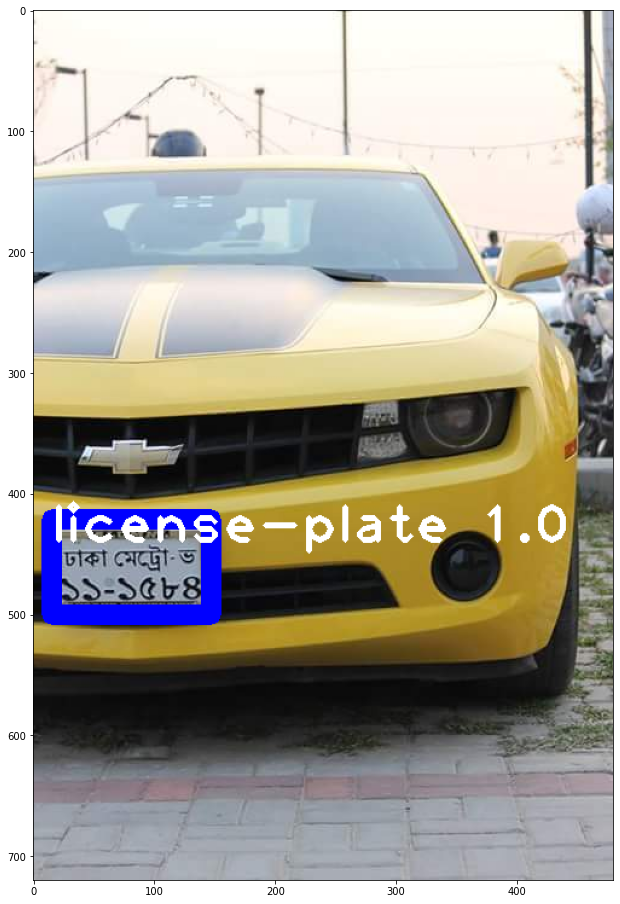

[([[6, 18], [122, 18], [122, 46], [6, 46]],
  'ঢাকা মেট্রো-ভ',
  0.47114653491460506),
 ([[3, 42], [126, 42], [126, 72], [3, 72]], '১১-১৫৮৪', 0.8278027606228116),
 ([[10, 70], [52, 70], [52, 78], [10, 78]], '18017|01', 0.004768510419388539)]

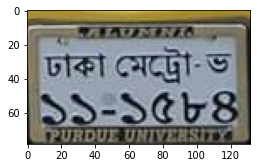

In [74]:
# Detect license plate
lpd.detect('images/48.jpg')

# Plot original image with rectangle around the plate
plt.figure(figsize=(16,16))
plt.imshow(cv2.cvtColor(lpd.fig_image, cv2.COLOR_BGR2RGB))
plt.show()

# Crop plate and show cropped plate
lpd.crop_plate()
plt.figure(figsize=(4, 4))
img_2=cv2.cvtColor(lpd.roi_image, cv2.COLOR_BGR2RGB)
plt.imshow(img_2)

detected_2= read_char.readtext(img_2)  #read from final extracted plate
detected_2

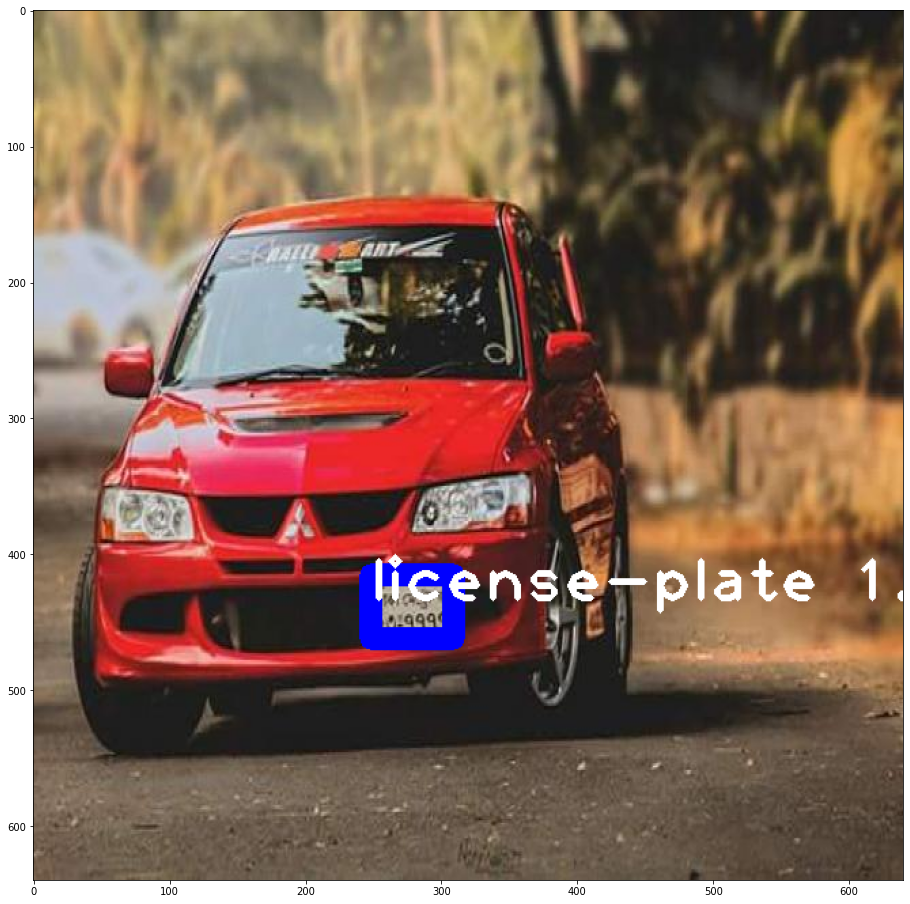

[([[0, 24], [61, 24], [61, 45], [0, 45]], '5৩-9999', 0.18239805553935792)]

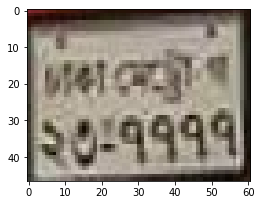

In [75]:
# Detect license plate
lpd.detect('valid/51_jpg.rf.41e732a6e4c6ec756ad5048b78714405.jpg')

# Plot original image with rectangle around the plate
plt.figure(figsize=(16,16))
plt.imshow(cv2.cvtColor(lpd.fig_image, cv2.COLOR_BGR2RGB))
plt.show()

# Crop plate and show cropped plate
lpd.crop_plate()
plt.figure(figsize=(4, 4))
img_3=cv2.cvtColor(lpd.roi_image, cv2.COLOR_BGR2RGB)
plt.imshow(img_3)

detected_3= read_char.readtext(img_3)  #read from final extracted plate
detected_3

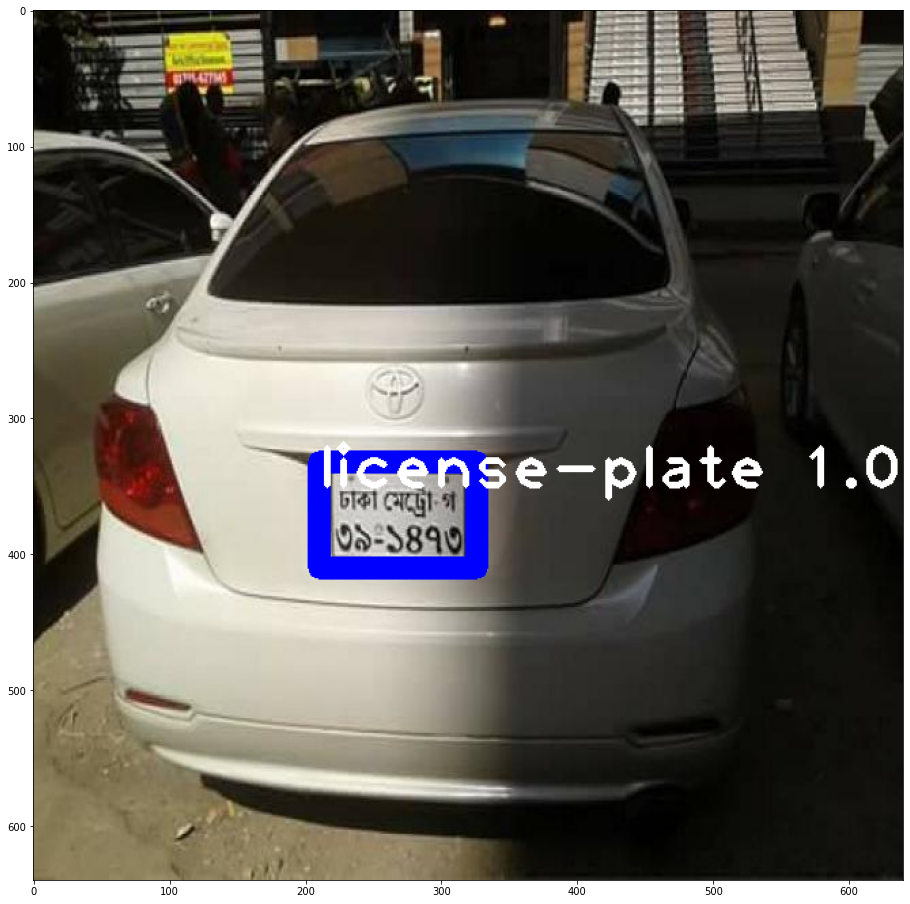

[([[10, 16], [90, 16], [90, 44], [10, 44]], 'ঢাকা মেটরেো', 0.3646103744970789),
 ([[10, 40], [108, 40], [108, 72], [10, 72]], '৩৯-১৪৭৩', 0.9724749967100054)]

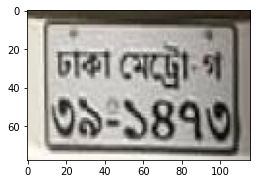

In [76]:
# Detect license plate
lpd.detect('valid/10_jpg.rf.95f1091e2eb9968fa78b736b34f143e9.jpg')

# Plot original image with rectangle around the plate
plt.figure(figsize=(16,16))
plt.imshow(cv2.cvtColor(lpd.fig_image, cv2.COLOR_BGR2RGB))
plt.show()

# Crop plate and show cropped plate
lpd.crop_plate()
plt.figure(figsize=(4, 4))
img_4=cv2.cvtColor(lpd.roi_image, cv2.COLOR_BGR2RGB)
plt.imshow(img_4)

detected_4= read_char.readtext(img_4)  #read from final extracted plate
detected_4